# First Approach - XGRegressor

30/11/2025

## Import Modules

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


## Import Data

In [3]:
data = pd.read_csv("data_20251117.csv", sep=";")
data.head()

,Classe,Nom,MS % brut,PB % brut,CB % brut,MGR % brut,MM % brut,NDF % brut,ADF % brut,Lignine % brut,...,Sucres % brut,EB (kcal) kcal/kg brut,ED porc croissance (kcal) kcal/kg brut,EM porc croissance (kcal) kcal/kg brut,EN porc croissance (kcal) kcal/kg brut,EMAn coq (kcal) kcal/kg brut,EMAn poulet (kcal) kcal/kg brut,UFL 2018 par kg brut,PDI 2018 g/kg brut,BalProRu 2018 g/kg brut
0,Céréales,Blé,90.800003,8.0,2.0,1.2,1.3,11.4,2.8,0.9,...,2.6,3900,3470,3380,2660,3060,2940,1.09,74,-40.0
1,Céréales,Blé,90.000000,8.0,1.9,1.2,1.4,11.0,2.7,0.9,...,2.6,3860,3450,3360,2640,3040,2920,1.08,73,-39.0
2,Céréales,Blé,89.000000,8.0,1.9,1.2,1.4,10.9,2.7,0.9,...,2.6,3820,3410,3320,2610,2980,2870,1.07,73,-38.0
3,Céréales,Blé,88.800003,8.0,1.9,1.2,1.4,10.9,2.7,0.9,...,2.6,3810,3400,3310,2600,2980,2860,1.07,73,-37.0
4,Céréales,Blé,88.500000,8.0,2.3,1.2,1.6,12.5,3.2,1.0,...,2.6,3790,3320,3230,2550,3000,2880,1.05,72,-36.0


In [4]:
# Colonnes explicatives
colonnes_X = [
    'Classe','Nom',
    'MS % brut','PB % brut','CB % brut','MGR % brut','MM % brut',
    'NDF % brut','ADF % brut','Lignine % brut',
    'Amidon % brut','Sucres % brut'
]

# Colonnes cibles
colonnes_Y = [
    'EB (kcal) kcal/kg brut',
    'ED porc croissance (kcal) kcal/kg brut',
    'EM porc croissance (kcal) kcal/kg brut',
    'EN porc croissance (kcal) kcal/kg brut',
    'EMAn coq (kcal) kcal/kg brut',
    'EMAn poulet (kcal) kcal/kg brut',
    'UFL 2018 par kg brut',
    'PDI 2018 g/kg brut',
    'BalProRu 2018 g/kg brut'
]

# Séparation des types de colonnes
colonnes_cat = ['Classe', 'Nom']
colonnes_num = [
    'MS % brut','PB % brut','CB % brut','MGR % brut','MM % brut',
    'NDF % brut','ADF % brut','Lignine % brut',
    'Amidon % brut','Sucres % brut'
]


## Affichage des boxplots pour les descripteurs numériques

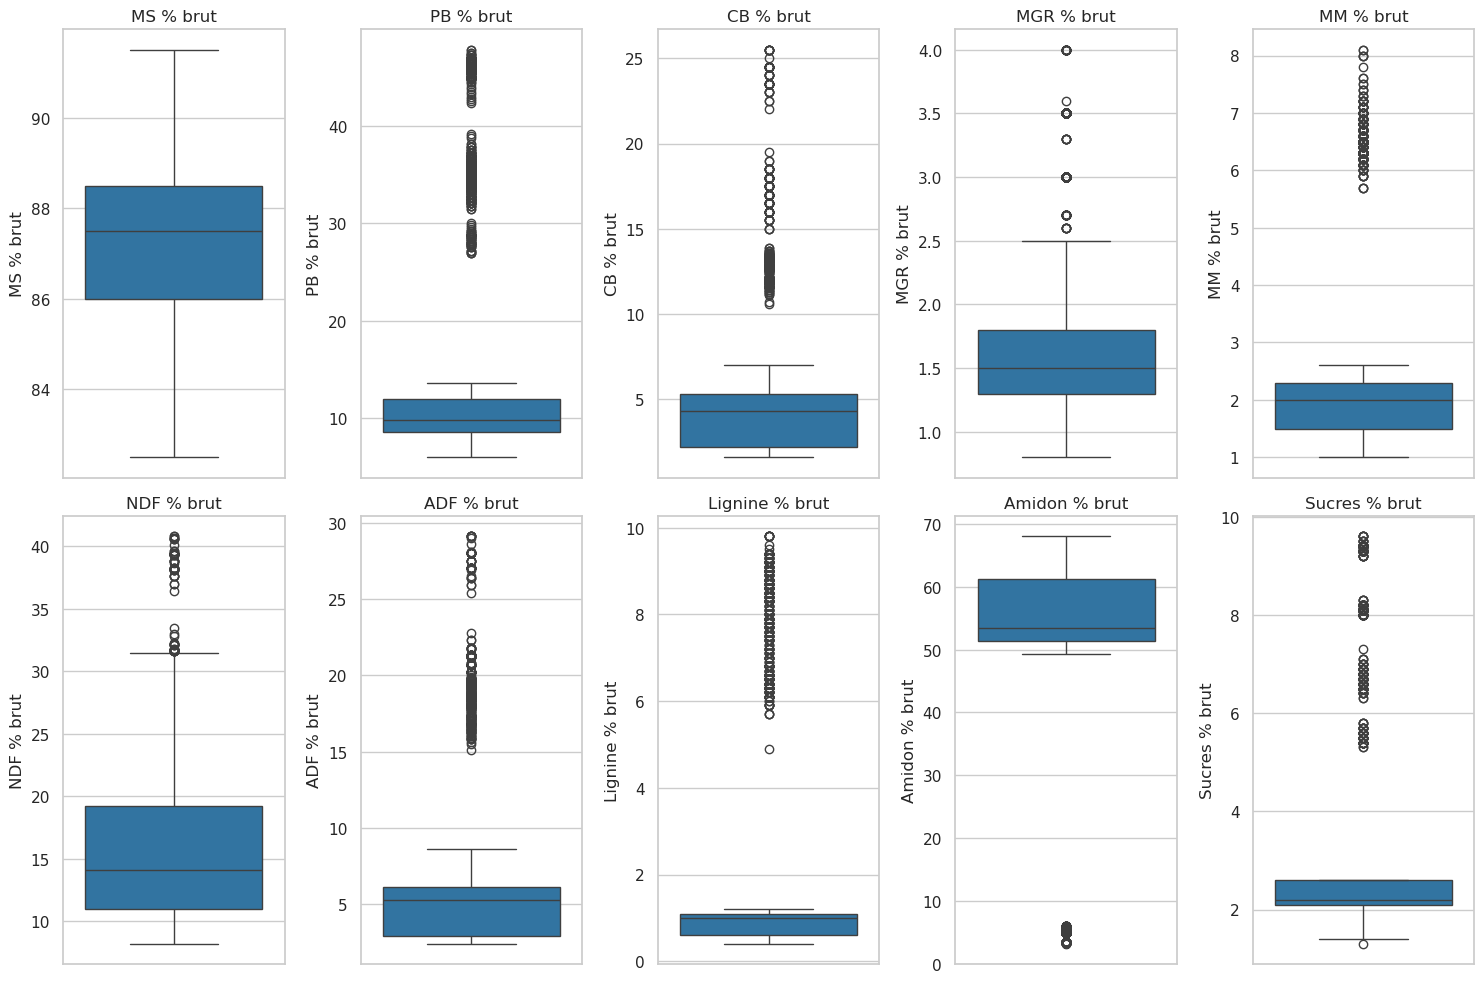

In [5]:
fig, axes = plt.subplots(2, 5, figsize=(15, 10))
axes = axes.flatten()

for ax, col in zip(axes, colonnes_num):
    sns.boxplot(y=data[col], ax=ax, color='tab:blue')
    ax.set_title(col)
    ax.set_xlabel("")
plt.tight_layout()
plt.show()


## Affichage des histogrammes pour les valeurs catégorielles

/tmp/ipykernel_33713/1219350380.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=data['Classe'], ax=axes[0], palette='Set2')
/tmp/ipykernel_33713/1219350380.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=data['Nom'], ax=axes[1], palette='Set3')


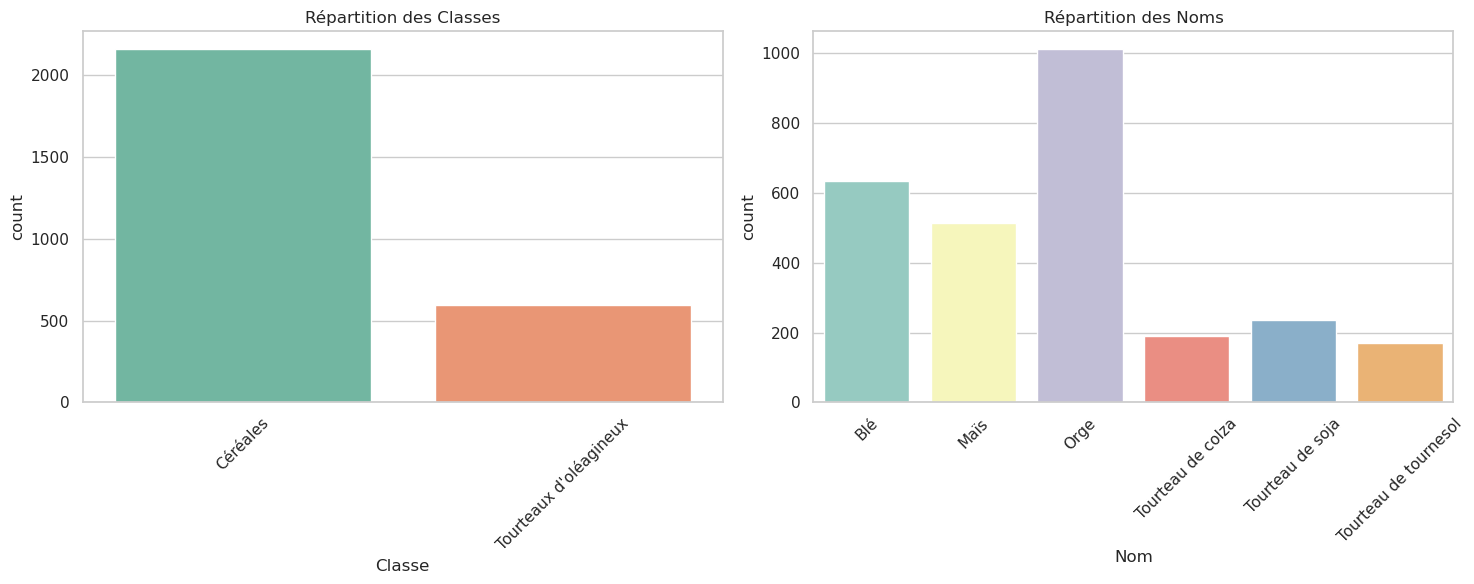

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Pour Classe
sns.countplot(x=data['Classe'], ax=axes[0], palette='Set2')
axes[0].set_title("Répartition des Classes")
axes[0].tick_params(axis='x', rotation=45)

# Pour Nom
sns.countplot(x=data['Nom'], ax=axes[1], palette='Set3')
axes[1].set_title("Répartition des Noms")
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


## One Hot encoding des variables catégorielles

In [7]:
# Pipeline de preprocessing : One-Hot pour les catégorielles + rien pour les numériques
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), colonnes_cat),
        ('num', 'passthrough', colonnes_num)
    ]
)

# On transforme X (sélection des colonnes explicatives)
X_raw = data[colonnes_X]

# Fit-transform
X_tot_enc_array = preprocessor.fit_transform(X_raw)

# Récupération des noms de colonnes
cat_cols_encoded = preprocessor.named_transformers_['cat'].get_feature_names_out(colonnes_cat)

colonnes_tot_enc = list(cat_cols_encoded) + colonnes_num

# Conversion en DataFrame propre
X_tot_enc = pd.DataFrame(
    X_tot_enc_array,
    columns=colonnes_tot_enc,
    index=data.index
)

X_tot_enc.head()


,Classe_Céréales,Classe_Tourteaux d'oléagineux,Nom_Blé,Nom_Maïs,Nom_Orge,Nom_Tourteau de colza,Nom_Tourteau de soja,Nom_Tourteau de tournesol,MS % brut,PB % brut,CB % brut,MGR % brut,MM % brut,NDF % brut,ADF % brut,Lignine % brut,Amidon % brut,Sucres % brut
0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,90.800003,8.0,2.0,1.2,1.3,11.4,2.8,0.9,65.099998,2.6
1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,90.000000,8.0,1.9,1.2,1.4,11.0,2.7,0.9,64.699997,2.6
2,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,89.000000,8.0,1.9,1.2,1.4,10.9,2.7,0.9,63.299999,2.6
3,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,88.800003,8.0,1.9,1.2,1.4,10.9,2.7,0.9,63.200001,2.6
4,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,88.500000,8.0,2.3,1.2,1.6,12.5,3.2,1.0,63.700001,2.6


## Split

In [8]:
from sklearn.model_selection import train_test_split

# split basé sur les index
train_idx, test_idx = train_test_split(
    data.index,
    test_size=0.30,
    random_state=42
)

X_train = X_tot_enc.loc[train_idx]
X_test  = X_tot_enc.loc[test_idx]

print(X_train.shape)
print(X_test.shape)


(1929, 18)
(827, 18)


## Fonction d'évaluation

In [9]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

def evaluation_regression(model, X_train, X_test, y_train, y_test, model_name=""):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    print(f"\n>>> {model_name}")
    print("  y_pred min/max :", round(y_pred.min(),3), "/", round(y_pred.max(),3))
    print(f"  MAE: {mae:.3f} | RMSE: {rmse:.3f} | R²: {r2:.3f}")

    return [model_name, mae, rmse, r2]

## Définition des cibles

In [10]:
targets = [
    'EB (kcal) kcal/kg brut',
    'ED porc croissance (kcal) kcal/kg brut',
    'EM porc croissance (kcal) kcal/kg brut',
    'EN porc croissance (kcal) kcal/kg brut',
    'EMAn coq (kcal) kcal/kg brut',
    'EMAn poulet (kcal) kcal/kg brut',
    'UFL 2018 par kg brut',
    'PDI 2018 g/kg brut',
    'BalProRu 2018 g/kg brut'
]


## Boucle d'évaluation

In [11]:
from xgboost import XGBRegressor

results_df = pd.DataFrame(columns=["Model_name", "MAE", "RMSE", "R2"])

for target in targets:
    y = data[target]               # série pandas complète
    y_train = y.loc[train_idx]
    y_test  = y.loc[test_idx]

    model = XGBRegressor(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=6,
        random_state=42
    )

    res = evaluation_regression(
        model,
        X_train, X_test,
        y_train, y_test,
        model_name=target
    )

    results_df.loc[len(results_df)] = res

results_df



>>> EB (kcal) kcal/kg brut
  y_pred min/max : 3592.012 / 4221.188
  MAE: 4.631 | RMSE: 6.128 | R²: 0.998

>>> ED porc croissance (kcal) kcal/kg brut
  y_pred min/max : 2091.706 / 3689.388
  MAE: 5.775 | RMSE: 8.489 | R²: 0.999

>>> EM porc croissance (kcal) kcal/kg brut
  y_pred min/max : 1911.549 / 3441.092
  MAE: 5.772 | RMSE: 8.234 | R²: 0.999

>>> EN porc croissance (kcal) kcal/kg brut
  y_pred min/max : 1091.923 / 2755.171
  MAE: 4.653 | RMSE: 6.563 | R²: 1.000

>>> EMAn coq (kcal) kcal/kg brut
  y_pred min/max : 1306.786 / 3310.796
  MAE: 5.458 | RMSE: 8.483 | R²: 1.000

>>> EMAn poulet (kcal) kcal/kg brut
  y_pred min/max : 1301.17 / 3236.102
  MAE: 5.569 | RMSE: 9.154 | R²: 1.000

>>> UFL 2018 par kg brut
  y_pred min/max : 0.605 / 1.165
  MAE: 0.003 | RMSE: 0.004 | R²: 0.999

>>> PDI 2018 g/kg brut
  y_pred min/max : 68.639 / 204.822
  MAE: 0.399 | RMSE: 1.521 | R²: 0.998

>>> BalProRu 2018 g/kg brut
  y_pred min/max : -55.283 / 223.307
  MAE: 0.433 | RMSE: 0.897 | R²: 1.000


,Model_name,MAE,RMSE,R2
0,EB (kcal) kcal/kg brut,4.630867,6.128421,0.998302
1,ED porc croissance (kcal) kcal/kg brut,5.775189,8.489241,0.998981
2,EM porc croissance (kcal) kcal/kg brut,5.771542,8.234018,0.999095
3,EN porc croissance (kcal) kcal/kg brut,4.652958,6.563491,0.999656
4,EMAn coq (kcal) kcal/kg brut,5.458238,8.483215,0.999693
5,EMAn poulet (kcal) kcal/kg brut,5.568848,9.153684,0.999644
6,UFL 2018 par kg brut,0.002975,0.003783,0.998611
7,PDI 2018 g/kg brut,0.399400,1.521269,0.998353
8,BalProRu 2018 g/kg brut,0.432775,0.897049,0.999900


# Test pour voir si le modèle peut généraliser à d'autres classes

Permet d'évaluer si les modèles ne possèdent pas de fuite de données quelquonque.
Nous essayons ici de prédire ce que nous avons jamais vu.

L'ensemble d'apprentissage contient toutes les céréales tandis que le test que les oléagineux.

In [12]:
idx_cereales = data.index[data["Classe"] == "Céréales"]
idx_oleagineux = data.index[data["Classe"] == "Tourteaux d'oléagineux"]

X_train_false = X_tot_enc.loc[idx_cereales]
X_test_false  = X_tot_enc.loc[idx_oleagineux]

y_train_false = data.loc[idx_cereales, "EM porc croissance (kcal) kcal/kg brut"]
y_test_false  = data.loc[idx_oleagineux, "EM porc croissance (kcal) kcal/kg brut"]

In [13]:
model = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    random_state=42
)

res_false = evaluation_regression(
    model,
    X_train_false,
    X_test_false,
    y_train_false,
    y_test_false,
    model_name="XGB_false_split_EM"
)

results_df.loc[len(results_df)] = res_false
results_df


>>> XGB_false_split_EM
  y_pred min/max : 2862.684 / 3184.512
  MAE: 376.761 | RMSE: 433.353 | R²: -0.048


,Model_name,MAE,RMSE,R2
0,EB (kcal) kcal/kg brut,4.630867,6.128421,0.998302
1,ED porc croissance (kcal) kcal/kg brut,5.775189,8.489241,0.998981
2,EM porc croissance (kcal) kcal/kg brut,5.771542,8.234018,0.999095
3,EN porc croissance (kcal) kcal/kg brut,4.652958,6.563491,0.999656
4,EMAn coq (kcal) kcal/kg brut,5.458238,8.483215,0.999693
5,EMAn poulet (kcal) kcal/kg brut,5.568848,9.153684,0.999644
6,UFL 2018 par kg brut,0.002975,0.003783,0.998611
7,PDI 2018 g/kg brut,0.399400,1.521269,0.998353
8,BalProRu 2018 g/kg brut,0.432775,0.897049,0.999900
9,XGB_false_split_EM,376.760895,433.352808,-0.047760


## Importance des variables pour notre modèle


>>> Importances pour EB (kcal) kcal/kg brut


/tmp/ipykernel_33713/1839426041.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feats.values, y=feats.index, palette="viridis")


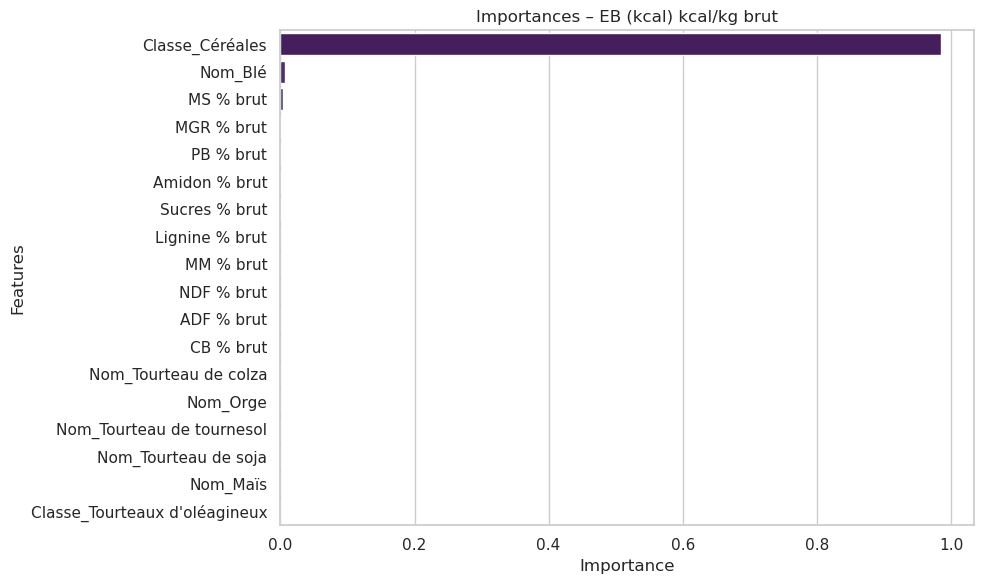


>>> Importances pour ED porc croissance (kcal) kcal/kg brut


/tmp/ipykernel_33713/1839426041.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feats.values, y=feats.index, palette="viridis")


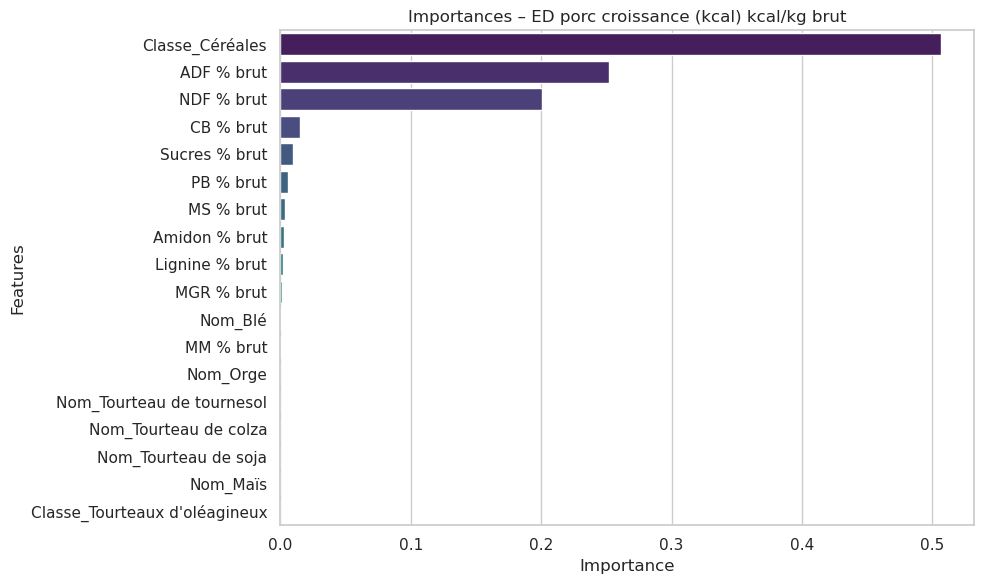


>>> Importances pour EM porc croissance (kcal) kcal/kg brut


/tmp/ipykernel_33713/1839426041.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feats.values, y=feats.index, palette="viridis")


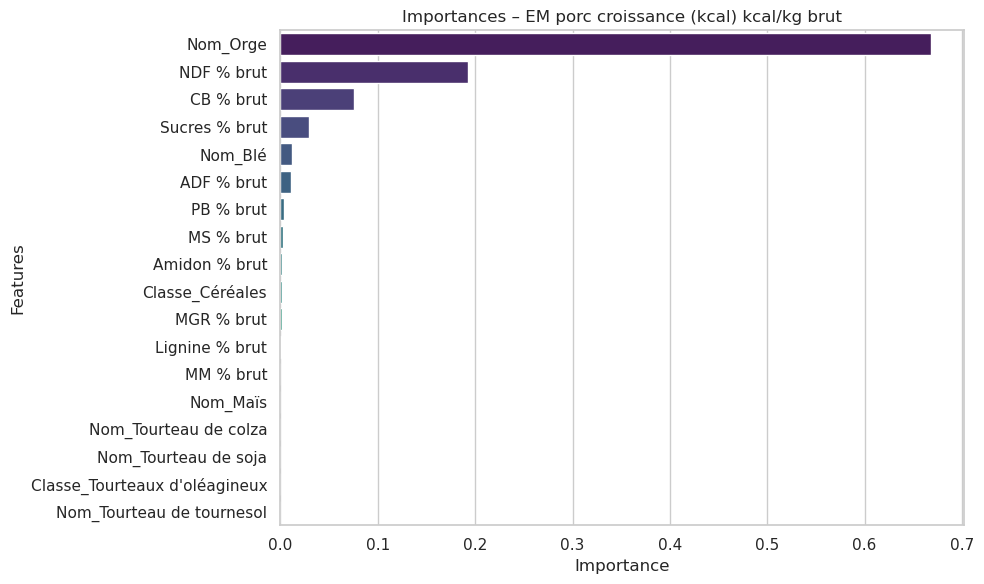


>>> Importances pour EN porc croissance (kcal) kcal/kg brut


/tmp/ipykernel_33713/1839426041.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feats.values, y=feats.index, palette="viridis")


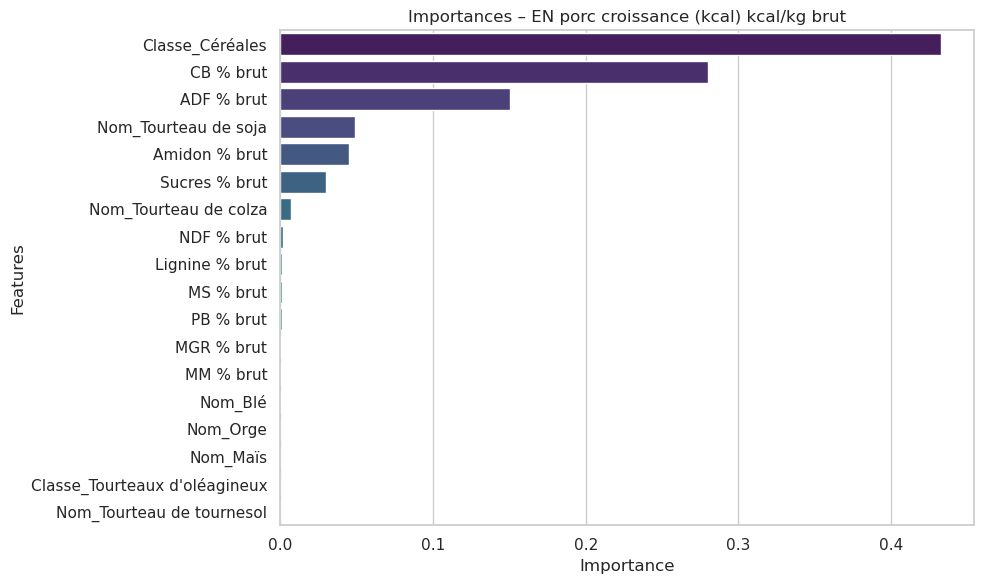


>>> Importances pour EMAn coq (kcal) kcal/kg brut


/tmp/ipykernel_33713/1839426041.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feats.values, y=feats.index, palette="viridis")


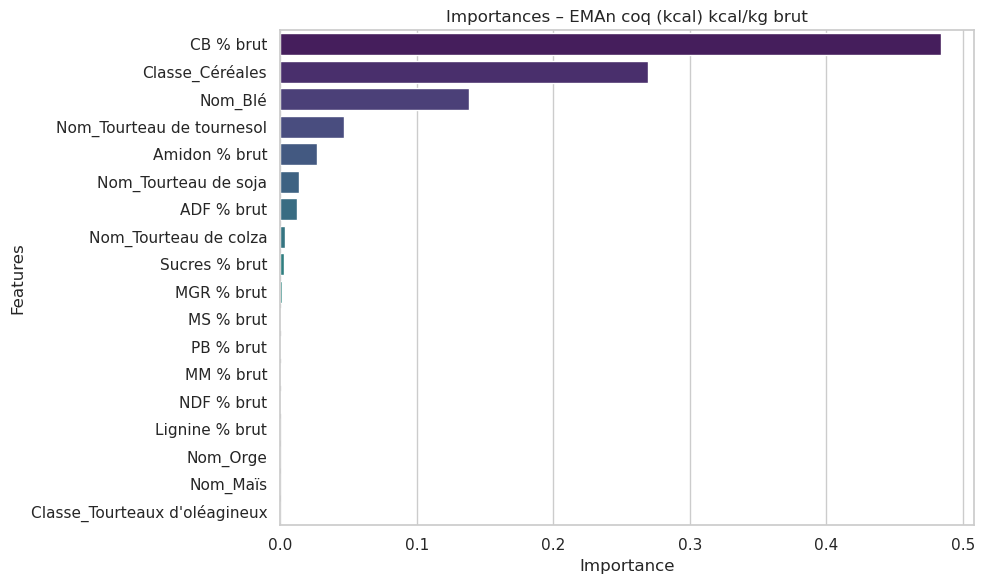


>>> Importances pour EMAn poulet (kcal) kcal/kg brut


/tmp/ipykernel_33713/1839426041.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feats.values, y=feats.index, palette="viridis")


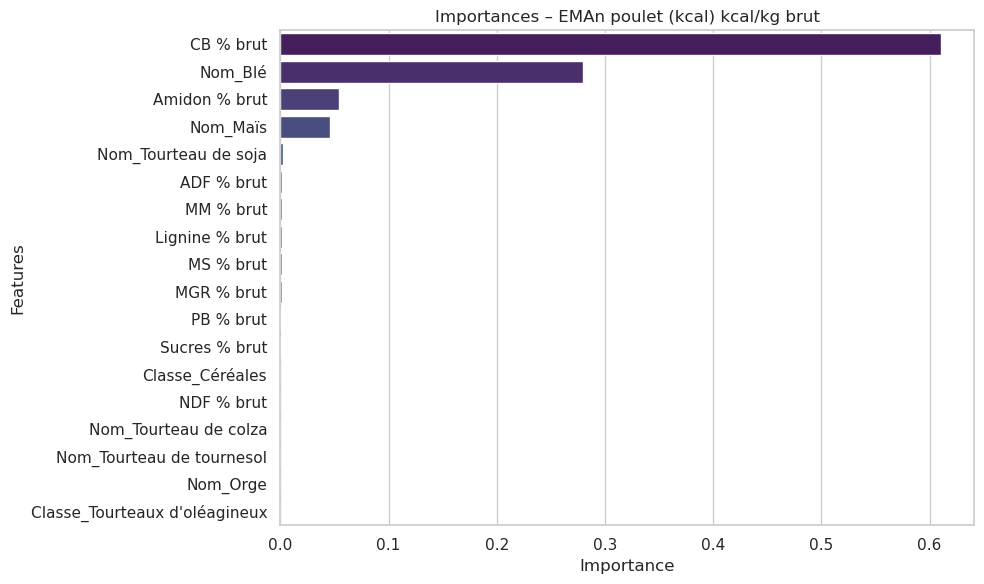


>>> Importances pour UFL 2018 par kg brut


/tmp/ipykernel_33713/1839426041.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feats.values, y=feats.index, palette="viridis")


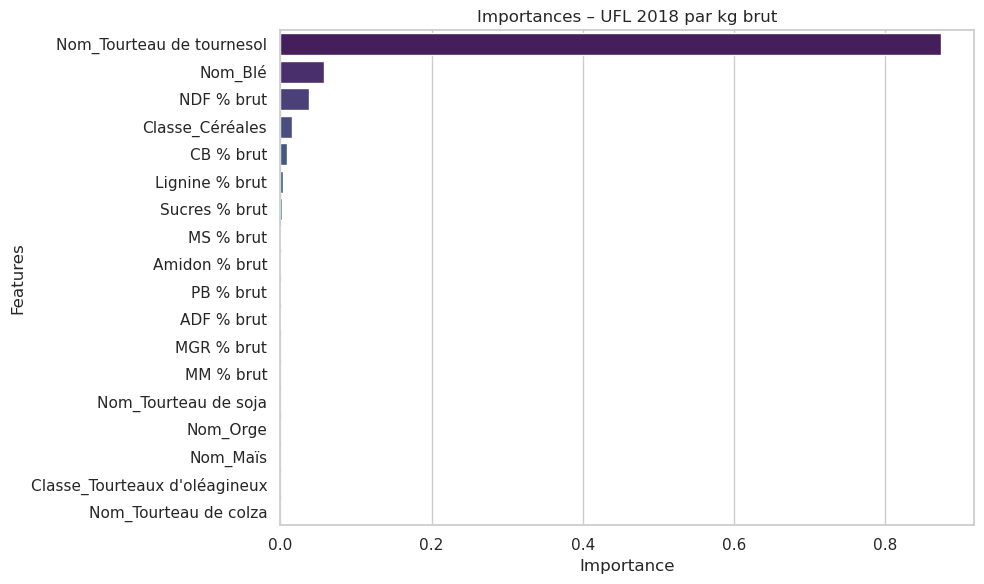


>>> Importances pour PDI 2018 g/kg brut


/tmp/ipykernel_33713/1839426041.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feats.values, y=feats.index, palette="viridis")


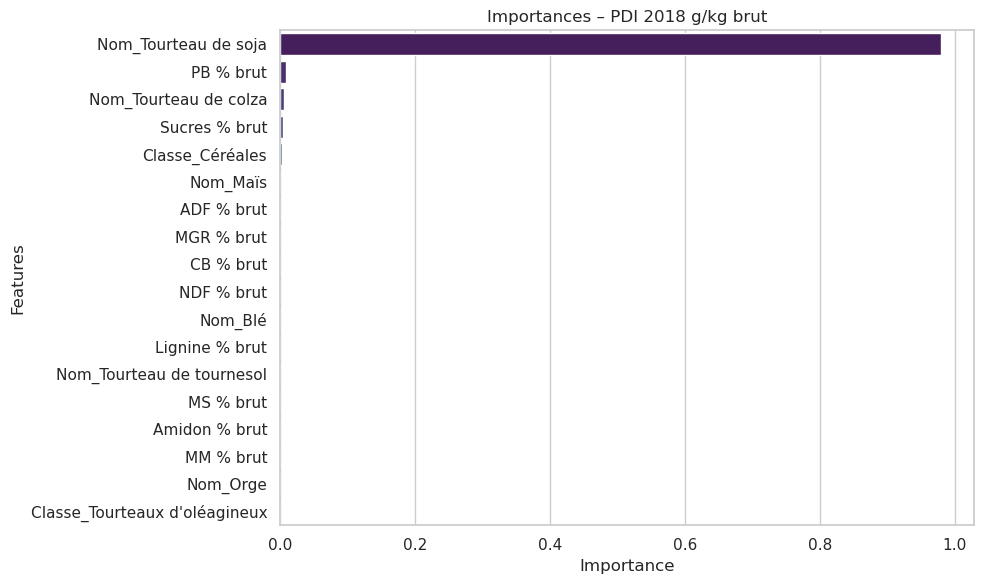


>>> Importances pour BalProRu 2018 g/kg brut


/tmp/ipykernel_33713/1839426041.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feats.values, y=feats.index, palette="viridis")


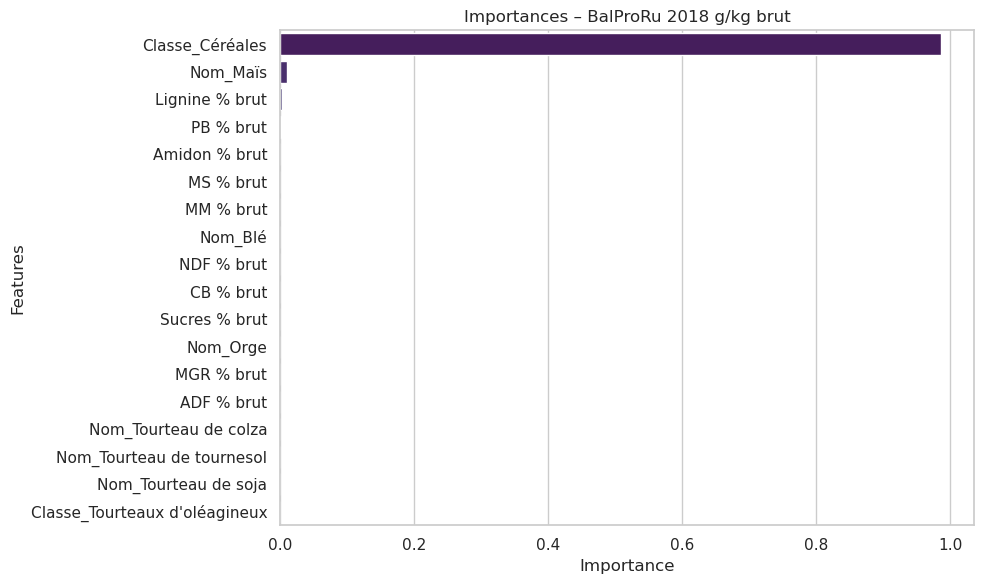

,EB (kcal) kcal/kg brut,ED porc croissance (kcal) kcal/kg brut,EM porc croissance (kcal) kcal/kg brut,EN porc croissance (kcal) kcal/kg brut,EMAn coq (kcal) kcal/kg brut,EMAn poulet (kcal) kcal/kg brut,UFL 2018 par kg brut,PDI 2018 g/kg brut,BalProRu 2018 g/kg brut
ADF % brut,0.000055,2.518305e-01,0.010575,0.150563,1.235484e-02,0.001895,0.000176,9.321565e-05,6.597998e-07
Amidon % brut,0.000700,2.528063e-03,0.001981,0.044620,2.709616e-02,0.053747,0.000367,3.612104e-06,2.075822e-05
CB % brut,0.000032,1.539454e-02,0.075328,0.279926,4.840359e-01,0.610511,0.008340,4.762907e-05,1.535171e-06
Classe_Céréales,0.984892,5.066025e-01,0.001900,0.432626,2.696286e-01,0.000081,0.015245,3.130163e-03,9.864454e-01
Classe_Tourteaux d'oléagineux,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00
Lignine % brut,0.000157,1.802817e-03,0.000851,0.001179,6.356954e-05,0.001417,0.003289,1.608291e-05,2.766886e-03
MGR % brut,0.000861,1.204306e-03,0.001210,0.000480,9.230176e-04,0.001149,0.000035,7.930794e-05,8.803714e-07
MM % brut,0.000117,1.770387e-04,0.000091,0.000360,2.341919e-04,0.001616,0.000024,8.493564e-07,3.159657e-06
MS % brut,0.004185,3.620473e-03,0.003168,0.001171,6.969001e-04,0.001171,0.000472,9.362591e-06,4.784659e-06
NDF % brut,0.000116,2.009495e-01,0.192204,0.001652,1.516603e-04,0.000055,0.037766,3.077215e-05,1.777177e-06


In [14]:
def xgb_feature_importances(model, X, title="Importance des variables"):
    importances = model.feature_importances_
    feats = pd.Series(importances, index=X.columns).sort_values(ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x=feats.values, y=feats.index, palette="viridis")
    plt.title(title)
    plt.xlabel("Importance")
    plt.ylabel("Features")
    plt.tight_layout()
    plt.show()

    return feats

feature_importances_dict = {}

for target in targets:
    y = data[target]
    y_train = y.loc[train_idx]
    y_test  = y.loc[test_idx]

    model = XGBRegressor(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=6,
        random_state=42
    )

    model.fit(X_train, y_train)

    print(f"\n>>> Importances pour {target}")
    feats = xgb_feature_importances(
        model, 
        X_train, 
        title=f"Importances – {target}"
    )

    feature_importances_dict[target] = feats

# Fusionner les importances dans un seul DataFrame
fi_df = pd.DataFrame(feature_importances_dict)
fi_df

Problème du one hot encoding = une grosse fuite de données donc une impossibilité de généralisé, sans l'encoding ce n'est pas tellement mieux car chaques sous classe (Nom) sont très différentiables les unes de autres. Le but est donc d'obtenir plus de données plus variés et d'entrainer le modèle sur le tout sans encoding afin que le modèle apprenne la biologie. 

Variables chimiques utilisées : ['MS % brut', 'PB % brut', 'CB % brut', 'MGR % brut', 'MM % brut', 'NDF % brut', 'ADF % brut', 'Lignine % brut', 'Amidon % brut', 'Sucres % brut']

=== Entraînement modèle pour EB ===

=== Entraînement modèle pour ED porc croissance ===

=== Entraînement modèle pour EM porc croissance ===

=== Entraînement modèle pour EN porc croissance ===

=== Entraînement modèle pour EMAn coq ===

=== Entraînement modèle pour EMAn poulet ===

=== Entraînement modèle pour UFL ===

=== Entraînement modèle pour PDI ===

=== Entraînement modèle pour BalProRu ===


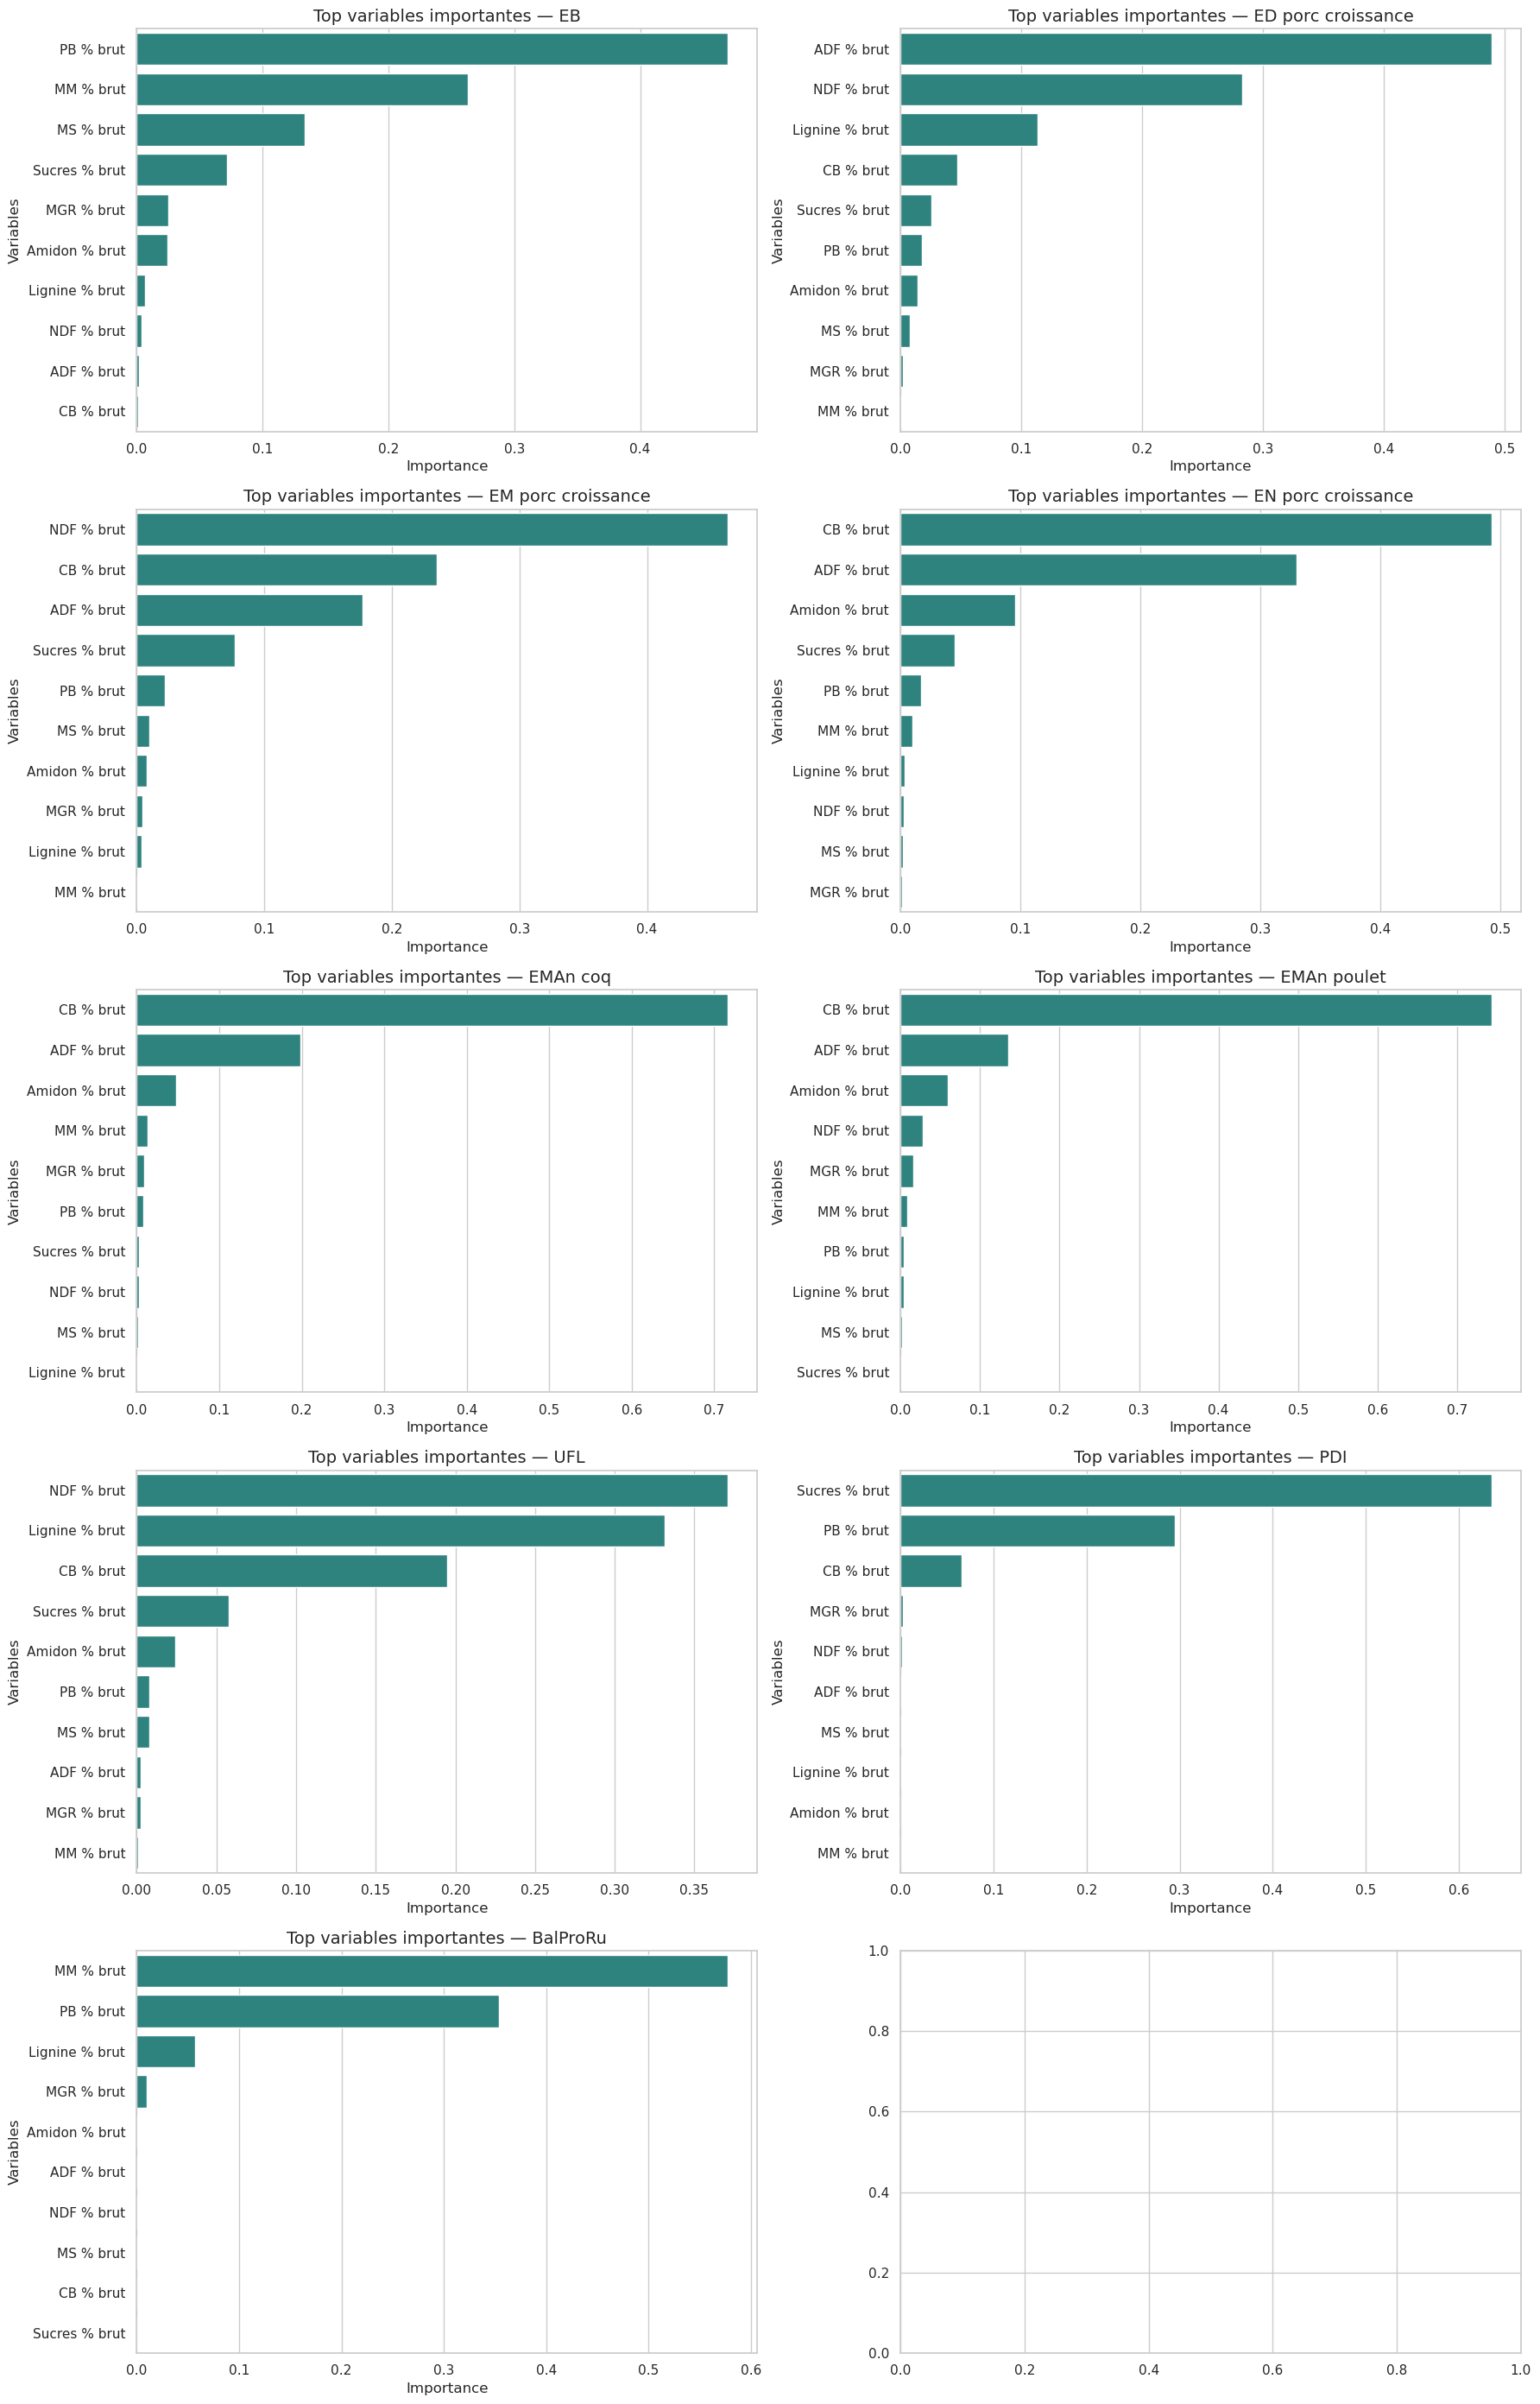

In [16]:
# ======================================
# IMPORTANCES XGBOOST – 8 CIBLES ÉNERGÉTIQUES
# Basé UNIQUEMENT sur les variables chimiques
# ======================================

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split

sns.set(style="whitegrid")

# ---------------------------
# 1. Définition des cibles
# ---------------------------

targets = {
    'EB'               : 'EB (kcal) kcal/kg brut',
    'ED porc croissance' : 'ED porc croissance (kcal) kcal/kg brut',
    'EM porc croissance' : 'EM porc croissance (kcal) kcal/kg brut',
    'EN porc croissance' : 'EN porc croissance (kcal) kcal/kg brut',
    'EMAn coq'           : 'EMAn coq (kcal) kcal/kg brut',
    'EMAn poulet'        : 'EMAn poulet (kcal) kcal/kg brut',
    'UFL'                : 'UFL 2018 par kg brut',
    'PDI'                : 'PDI 2018 g/kg brut',
    'BalProRu'           : 'BalProRu 2018 g/kg brut'
}

# ---------------------------
# 2. X = uniquement variables chimiques
# ---------------------------

X = data[colonnes_num].copy()    # colonnes_num vient de ton notebook
print("Variables chimiques utilisées :", X.columns.tolist())

# ---------------------------
# 3. Split commun
# ---------------------------

train_idx, test_idx = train_test_split(
    X.index, test_size=0.2, random_state=62
)

X_train = X.loc[train_idx]
X_test  = X.loc[test_idx]

# ---------------------------
# 4. Entraînement + importances
# ---------------------------

feature_importances_all = {}

for label, col in targets.items():

    print(f"\n=== Entraînement modèle pour {label} ===")

    y = data[col]
    y_train = y.loc[train_idx]
    y_test  = y.loc[test_idx]

    model = xgb.XGBRegressor(
        n_estimators=250,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.9,
        colsample_bytree=0.9,
        random_state=42
    )

    model.fit(X_train, y_train)

    importances = pd.Series(
        model.feature_importances_,
        index=X.columns
    ).sort_values(ascending=False)

    feature_importances_all[label] = importances


# ---------------------------
# 5. Visualisation : 9 graphes
# ---------------------------

fig, axes = plt.subplots(5, 2, figsize=(18, 28))
axes = axes.flatten()

for i, (label, importances) in enumerate(feature_importances_all.items()):

    top = importances.head(12)

    sns.barplot(
        x=top.values,
        y=top.index,
        hue=[label]*len(top),
        dodge=False,
        palette="viridis",
        ax=axes[i]
    )

    axes[i].set_title(f"Top variables importantes — {label}", fontsize=14)
    axes[i].set_xlabel("Importance")
    axes[i].set_ylabel("Variables")
    axes[i].get_legend().remove()

plt.tight_layout()
plt.show()


## Analyse afin de savoir à partir de combien de points par sous-classe = "Nom", le modèle devient moins bon

Cela permettra de savoir combien de points par "Nom", à peu près demander aux commanditaires pour enrichir notre jeu de données.

Nombre minimal par sous-classe : 171

===== Cible : EB =====


/tmp/ipykernel_33713/1922567136.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=n, random_state=42))


n=171 → R² = 0.997 ± 0.001


/tmp/ipykernel_33713/1922567136.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=n, random_state=42))


n=161 → R² = 0.997 ± 0.001


/tmp/ipykernel_33713/1922567136.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=n, random_state=42))


n=151 → R² = 0.997 ± 0.001


/tmp/ipykernel_33713/1922567136.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=n, random_state=42))


n=141 → R² = 0.997 ± 0.001


/tmp/ipykernel_33713/1922567136.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=n, random_state=42))


n=131 → R² = 0.997 ± 0.002


/tmp/ipykernel_33713/1922567136.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=n, random_state=42))


n=121 → R² = 0.997 ± 0.001


/tmp/ipykernel_33713/1922567136.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=n, random_state=42))


n=111 → R² = 0.997 ± 0.001


/tmp/ipykernel_33713/1922567136.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=n, random_state=42))


n=101 → R² = 0.996 ± 0.002


/tmp/ipykernel_33713/1922567136.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=n, random_state=42))


n=91 → R² = 0.996 ± 0.002


/tmp/ipykernel_33713/1922567136.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=n, random_state=42))


n=81 → R² = 0.995 ± 0.002


/tmp/ipykernel_33713/1922567136.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=n, random_state=42))


n=71 → R² = 0.995 ± 0.002


/tmp/ipykernel_33713/1922567136.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=n, random_state=42))


n=61 → R² = 0.993 ± 0.004


/tmp/ipykernel_33713/1922567136.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=n, random_state=42))


n=51 → R² = 0.992 ± 0.003


/tmp/ipykernel_33713/1922567136.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=n, random_state=42))


n=41 → R² = 0.990 ± 0.005


/tmp/ipykernel_33713/1922567136.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=n, random_state=42))


n=31 → R² = 0.988 ± 0.006


/tmp/ipykernel_33713/1922567136.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=n, random_state=42))


n=21 → R² = 0.976 ± 0.020


/tmp/ipykernel_33713/1922567136.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=n, random_state=42))


n=11 → R² = 0.974 ± 0.017

===== Cible : ED porc croissance =====


/tmp/ipykernel_33713/1922567136.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=n, random_state=42))


n=171 → R² = 0.999 ± 0.000


/tmp/ipykernel_33713/1922567136.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=n, random_state=42))


n=161 → R² = 0.999 ± 0.001


/tmp/ipykernel_33713/1922567136.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=n, random_state=42))


n=151 → R² = 0.999 ± 0.001


/tmp/ipykernel_33713/1922567136.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=n, random_state=42))


n=141 → R² = 0.998 ± 0.001


/tmp/ipykernel_33713/1922567136.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=n, random_state=42))


n=131 → R² = 0.998 ± 0.001


/tmp/ipykernel_33713/1922567136.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=n, random_state=42))


n=121 → R² = 0.998 ± 0.000


/tmp/ipykernel_33713/1922567136.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=n, random_state=42))


n=111 → R² = 0.998 ± 0.001


/tmp/ipykernel_33713/1922567136.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=n, random_state=42))


n=101 → R² = 0.998 ± 0.000


/tmp/ipykernel_33713/1922567136.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=n, random_state=42))


n=91 → R² = 0.998 ± 0.001


/tmp/ipykernel_33713/1922567136.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=n, random_state=42))


n=81 → R² = 0.998 ± 0.001


/tmp/ipykernel_33713/1922567136.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=n, random_state=42))


n=71 → R² = 0.997 ± 0.001


/tmp/ipykernel_33713/1922567136.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=n, random_state=42))


n=61 → R² = 0.996 ± 0.002


/tmp/ipykernel_33713/1922567136.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=n, random_state=42))


n=51 → R² = 0.996 ± 0.002


/tmp/ipykernel_33713/1922567136.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=n, random_state=42))


n=41 → R² = 0.995 ± 0.002


/tmp/ipykernel_33713/1922567136.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=n, random_state=42))


n=31 → R² = 0.992 ± 0.003


/tmp/ipykernel_33713/1922567136.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=n, random_state=42))


n=21 → R² = 0.988 ± 0.007


/tmp/ipykernel_33713/1922567136.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=n, random_state=42))


n=11 → R² = 0.961 ± 0.034

===== Cible : EM porc croissance =====


/tmp/ipykernel_33713/1922567136.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=n, random_state=42))


n=171 → R² = 0.999 ± 0.000


/tmp/ipykernel_33713/1922567136.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=n, random_state=42))


n=161 → R² = 0.999 ± 0.000


/tmp/ipykernel_33713/1922567136.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=n, random_state=42))


n=151 → R² = 0.999 ± 0.000


/tmp/ipykernel_33713/1922567136.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=n, random_state=42))


n=141 → R² = 0.999 ± 0.001


/tmp/ipykernel_33713/1922567136.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=n, random_state=42))


n=131 → R² = 0.999 ± 0.001


/tmp/ipykernel_33713/1922567136.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=n, random_state=42))


n=121 → R² = 0.998 ± 0.001


/tmp/ipykernel_33713/1922567136.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=n, random_state=42))


n=111 → R² = 0.999 ± 0.001


/tmp/ipykernel_33713/1922567136.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=n, random_state=42))


n=101 → R² = 0.998 ± 0.001


/tmp/ipykernel_33713/1922567136.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=n, random_state=42))


n=91 → R² = 0.998 ± 0.001


/tmp/ipykernel_33713/1922567136.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=n, random_state=42))


n=81 → R² = 0.998 ± 0.000


/tmp/ipykernel_33713/1922567136.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=n, random_state=42))


n=71 → R² = 0.998 ± 0.001


/tmp/ipykernel_33713/1922567136.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=n, random_state=42))


n=61 → R² = 0.997 ± 0.001


/tmp/ipykernel_33713/1922567136.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=n, random_state=42))


n=51 → R² = 0.997 ± 0.002


/tmp/ipykernel_33713/1922567136.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=n, random_state=42))


n=41 → R² = 0.996 ± 0.001


/tmp/ipykernel_33713/1922567136.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=n, random_state=42))


n=31 → R² = 0.994 ± 0.004


/tmp/ipykernel_33713/1922567136.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=n, random_state=42))


n=21 → R² = 0.992 ± 0.006


/tmp/ipykernel_33713/1922567136.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=n, random_state=42))


n=11 → R² = 0.979 ± 0.019

===== Cible : EN porc croissance =====


/tmp/ipykernel_33713/1922567136.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=n, random_state=42))


n=171 → R² = 0.999 ± 0.001


/tmp/ipykernel_33713/1922567136.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=n, random_state=42))


n=161 → R² = 0.999 ± 0.001


/tmp/ipykernel_33713/1922567136.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=n, random_state=42))


n=151 → R² = 0.999 ± 0.001


/tmp/ipykernel_33713/1922567136.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=n, random_state=42))


n=141 → R² = 0.999 ± 0.001


/tmp/ipykernel_33713/1922567136.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=n, random_state=42))


n=131 → R² = 0.999 ± 0.001


/tmp/ipykernel_33713/1922567136.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=n, random_state=42))


n=121 → R² = 0.999 ± 0.002


/tmp/ipykernel_33713/1922567136.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=n, random_state=42))


n=111 → R² = 0.999 ± 0.001


/tmp/ipykernel_33713/1922567136.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=n, random_state=42))


n=101 → R² = 0.999 ± 0.001


/tmp/ipykernel_33713/1922567136.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=n, random_state=42))


n=91 → R² = 0.999 ± 0.001


/tmp/ipykernel_33713/1922567136.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=n, random_state=42))


n=81 → R² = 0.999 ± 0.001


/tmp/ipykernel_33713/1922567136.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=n, random_state=42))


n=71 → R² = 0.998 ± 0.001


/tmp/ipykernel_33713/1922567136.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=n, random_state=42))


n=61 → R² = 0.998 ± 0.002


/tmp/ipykernel_33713/1922567136.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=n, random_state=42))


n=51 → R² = 0.998 ± 0.002


/tmp/ipykernel_33713/1922567136.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=n, random_state=42))


n=41 → R² = 0.997 ± 0.003


/tmp/ipykernel_33713/1922567136.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=n, random_state=42))


n=31 → R² = 0.995 ± 0.007


/tmp/ipykernel_33713/1922567136.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=n, random_state=42))


n=21 → R² = 0.987 ± 0.027


/tmp/ipykernel_33713/1922567136.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=n, random_state=42))


n=11 → R² = 0.992 ± 0.007

===== Cible : EMAn coq =====


/tmp/ipykernel_33713/1922567136.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=n, random_state=42))


n=171 → R² = 0.999 ± 0.002


/tmp/ipykernel_33713/1922567136.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=n, random_state=42))


n=161 → R² = 0.999 ± 0.002


/tmp/ipykernel_33713/1922567136.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=n, random_state=42))


n=151 → R² = 0.999 ± 0.002


/tmp/ipykernel_33713/1922567136.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=n, random_state=42))


n=141 → R² = 0.999 ± 0.003


/tmp/ipykernel_33713/1922567136.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=n, random_state=42))


n=131 → R² = 0.999 ± 0.003


/tmp/ipykernel_33713/1922567136.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=n, random_state=42))


n=121 → R² = 0.998 ± 0.006


/tmp/ipykernel_33713/1922567136.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=n, random_state=42))


n=111 → R² = 0.998 ± 0.004


/tmp/ipykernel_33713/1922567136.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=n, random_state=42))


n=101 → R² = 0.998 ± 0.003


/tmp/ipykernel_33713/1922567136.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=n, random_state=42))


n=91 → R² = 0.998 ± 0.004


/tmp/ipykernel_33713/1922567136.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=n, random_state=42))


n=81 → R² = 0.998 ± 0.005


/tmp/ipykernel_33713/1922567136.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=n, random_state=42))


n=71 → R² = 0.998 ± 0.005


/tmp/ipykernel_33713/1922567136.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=n, random_state=42))


n=61 → R² = 0.997 ± 0.006


/tmp/ipykernel_33713/1922567136.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=n, random_state=42))


n=51 → R² = 0.996 ± 0.008


/tmp/ipykernel_33713/1922567136.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=n, random_state=42))


n=41 → R² = 0.996 ± 0.010


/tmp/ipykernel_33713/1922567136.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=n, random_state=42))


n=31 → R² = 0.992 ± 0.019


/tmp/ipykernel_33713/1922567136.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=n, random_state=42))


n=21 → R² = 0.990 ± 0.025


/tmp/ipykernel_33713/1922567136.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=n, random_state=42))


n=11 → R² = 0.987 ± 0.025

===== Cible : EMAn poulet =====


/tmp/ipykernel_33713/1922567136.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=n, random_state=42))


n=171 → R² = 0.998 ± 0.004


/tmp/ipykernel_33713/1922567136.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=n, random_state=42))


n=161 → R² = 0.998 ± 0.004


/tmp/ipykernel_33713/1922567136.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=n, random_state=42))


n=151 → R² = 0.998 ± 0.004


/tmp/ipykernel_33713/1922567136.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=n, random_state=42))


n=141 → R² = 0.998 ± 0.005


/tmp/ipykernel_33713/1922567136.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=n, random_state=42))


n=131 → R² = 0.998 ± 0.004


/tmp/ipykernel_33713/1922567136.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=n, random_state=42))


n=121 → R² = 0.996 ± 0.010


/tmp/ipykernel_33713/1922567136.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=n, random_state=42))


n=111 → R² = 0.998 ± 0.006


/tmp/ipykernel_33713/1922567136.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=n, random_state=42))


n=101 → R² = 0.998 ± 0.005


/tmp/ipykernel_33713/1922567136.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=n, random_state=42))


n=91 → R² = 0.997 ± 0.006


/tmp/ipykernel_33713/1922567136.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=n, random_state=42))


n=81 → R² = 0.997 ± 0.007


/tmp/ipykernel_33713/1922567136.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=n, random_state=42))


n=71 → R² = 0.996 ± 0.008


/tmp/ipykernel_33713/1922567136.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=n, random_state=42))


n=61 → R² = 0.996 ± 0.010


/tmp/ipykernel_33713/1922567136.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=n, random_state=42))


n=51 → R² = 0.995 ± 0.014


/tmp/ipykernel_33713/1922567136.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=n, random_state=42))


n=41 → R² = 0.993 ± 0.015


/tmp/ipykernel_33713/1922567136.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=n, random_state=42))


n=31 → R² = 0.990 ± 0.024


/tmp/ipykernel_33713/1922567136.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=n, random_state=42))


n=21 → R² = 0.982 ± 0.043


/tmp/ipykernel_33713/1922567136.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=n, random_state=42))


n=11 → R² = 0.980 ± 0.041

===== Cible : UFL =====


/tmp/ipykernel_33713/1922567136.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=n, random_state=42))


n=171 → R² = 0.999 ± 0.000


/tmp/ipykernel_33713/1922567136.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=n, random_state=42))


n=161 → R² = 0.999 ± 0.000


/tmp/ipykernel_33713/1922567136.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=n, random_state=42))


n=151 → R² = 0.999 ± 0.000


/tmp/ipykernel_33713/1922567136.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=n, random_state=42))


n=141 → R² = 0.999 ± 0.000


/tmp/ipykernel_33713/1922567136.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=n, random_state=42))


n=131 → R² = 0.999 ± 0.000


/tmp/ipykernel_33713/1922567136.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=n, random_state=42))


n=121 → R² = 0.999 ± 0.001


/tmp/ipykernel_33713/1922567136.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=n, random_state=42))


n=111 → R² = 0.999 ± 0.000


/tmp/ipykernel_33713/1922567136.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=n, random_state=42))


n=101 → R² = 0.998 ± 0.000


/tmp/ipykernel_33713/1922567136.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=n, random_state=42))


n=91 → R² = 0.998 ± 0.000


/tmp/ipykernel_33713/1922567136.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=n, random_state=42))


n=81 → R² = 0.998 ± 0.000


/tmp/ipykernel_33713/1922567136.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=n, random_state=42))


n=71 → R² = 0.998 ± 0.001


/tmp/ipykernel_33713/1922567136.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=n, random_state=42))


n=61 → R² = 0.997 ± 0.002


/tmp/ipykernel_33713/1922567136.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=n, random_state=42))


n=51 → R² = 0.998 ± 0.001


/tmp/ipykernel_33713/1922567136.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=n, random_state=42))


n=41 → R² = 0.996 ± 0.002


/tmp/ipykernel_33713/1922567136.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=n, random_state=42))


n=31 → R² = 0.993 ± 0.004


/tmp/ipykernel_33713/1922567136.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=n, random_state=42))


n=21 → R² = 0.993 ± 0.002


/tmp/ipykernel_33713/1922567136.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=n, random_state=42))


n=11 → R² = 0.981 ± 0.013

===== Cible : PDI =====


/tmp/ipykernel_33713/1922567136.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=n, random_state=42))


n=171 → R² = 0.999 ± 0.002


/tmp/ipykernel_33713/1922567136.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=n, random_state=42))


n=161 → R² = 0.999 ± 0.002


/tmp/ipykernel_33713/1922567136.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=n, random_state=42))


n=151 → R² = 0.999 ± 0.002


/tmp/ipykernel_33713/1922567136.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=n, random_state=42))


n=141 → R² = 0.999 ± 0.002


/tmp/ipykernel_33713/1922567136.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=n, random_state=42))


n=131 → R² = 0.999 ± 0.002


/tmp/ipykernel_33713/1922567136.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=n, random_state=42))


n=121 → R² = 0.998 ± 0.004


/tmp/ipykernel_33713/1922567136.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=n, random_state=42))


n=111 → R² = 0.998 ± 0.004


/tmp/ipykernel_33713/1922567136.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=n, random_state=42))


n=101 → R² = 0.999 ± 0.003


/tmp/ipykernel_33713/1922567136.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=n, random_state=42))


n=91 → R² = 0.998 ± 0.004


/tmp/ipykernel_33713/1922567136.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=n, random_state=42))


n=81 → R² = 0.998 ± 0.004


/tmp/ipykernel_33713/1922567136.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=n, random_state=42))


n=71 → R² = 0.999 ± 0.000


/tmp/ipykernel_33713/1922567136.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=n, random_state=42))


n=61 → R² = 0.999 ± 0.001


/tmp/ipykernel_33713/1922567136.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=n, random_state=42))


n=51 → R² = 0.999 ± 0.001


/tmp/ipykernel_33713/1922567136.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=n, random_state=42))


n=41 → R² = 0.999 ± 0.001


/tmp/ipykernel_33713/1922567136.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=n, random_state=42))


n=31 → R² = 0.991 ± 0.020


/tmp/ipykernel_33713/1922567136.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=n, random_state=42))


n=21 → R² = 0.991 ± 0.018


/tmp/ipykernel_33713/1922567136.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=n, random_state=42))


n=11 → R² = 0.987 ± 0.030

===== Cible : BalProRu =====


/tmp/ipykernel_33713/1922567136.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=n, random_state=42))


n=171 → R² = 1.000 ± 0.000


/tmp/ipykernel_33713/1922567136.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=n, random_state=42))


n=161 → R² = 1.000 ± 0.000


/tmp/ipykernel_33713/1922567136.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=n, random_state=42))


n=151 → R² = 1.000 ± 0.000


/tmp/ipykernel_33713/1922567136.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=n, random_state=42))


n=141 → R² = 1.000 ± 0.000


/tmp/ipykernel_33713/1922567136.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=n, random_state=42))


n=131 → R² = 0.998 ± 0.006


/tmp/ipykernel_33713/1922567136.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=n, random_state=42))


n=121 → R² = 1.000 ± 0.001


/tmp/ipykernel_33713/1922567136.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=n, random_state=42))


n=111 → R² = 1.000 ± 0.001


/tmp/ipykernel_33713/1922567136.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=n, random_state=42))


n=101 → R² = 1.000 ± 0.001


/tmp/ipykernel_33713/1922567136.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=n, random_state=42))


n=91 → R² = 1.000 ± 0.001


/tmp/ipykernel_33713/1922567136.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=n, random_state=42))


n=81 → R² = 0.999 ± 0.001


/tmp/ipykernel_33713/1922567136.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=n, random_state=42))


n=71 → R² = 0.997 ± 0.006


/tmp/ipykernel_33713/1922567136.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=n, random_state=42))


n=61 → R² = 0.994 ± 0.016


/tmp/ipykernel_33713/1922567136.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=n, random_state=42))


n=51 → R² = 0.996 ± 0.008


/tmp/ipykernel_33713/1922567136.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=n, random_state=42))


n=41 → R² = 0.996 ± 0.010


/tmp/ipykernel_33713/1922567136.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=n, random_state=42))


n=31 → R² = 0.998 ± 0.003


/tmp/ipykernel_33713/1922567136.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=n, random_state=42))


n=21 → R² = 0.992 ± 0.023


/tmp/ipykernel_33713/1922567136.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=n, random_state=42))


n=11 → R² = 0.999 ± 0.001


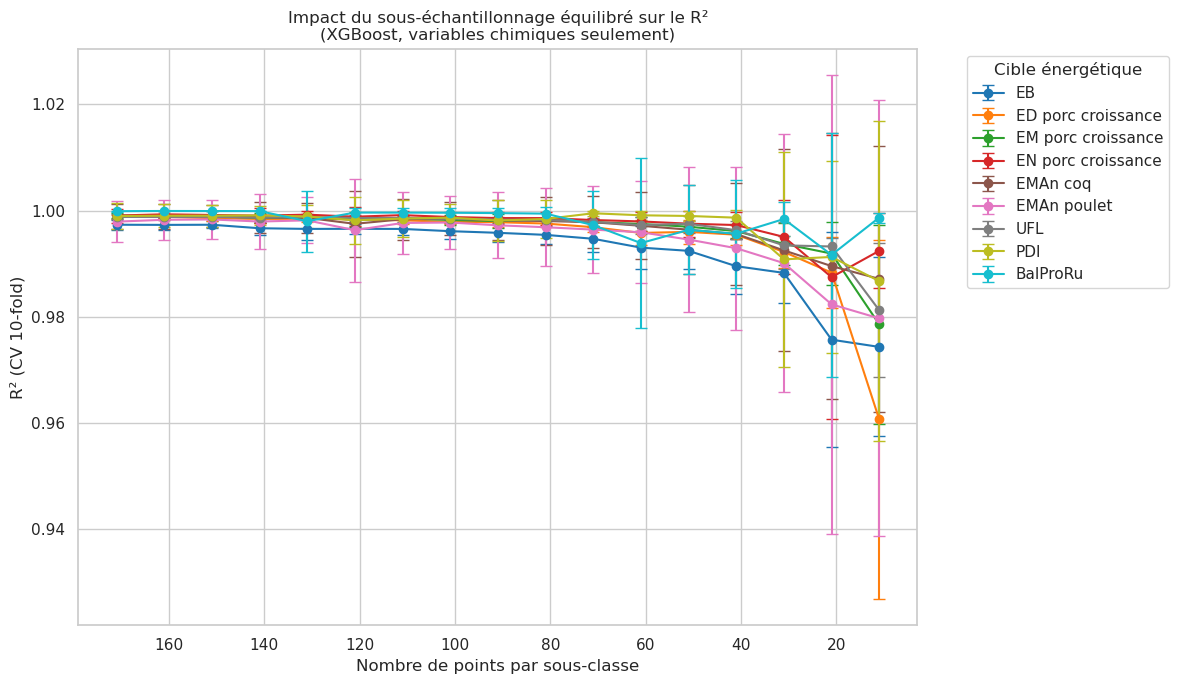

{'EB':     n_points   R2_mean    R2_std
 0        171  0.997330  0.000967
 1        161  0.997299  0.001010
 2        151  0.997327  0.000675
 3        141  0.996667  0.001181
 4        131  0.996543  0.002163
 5        121  0.996562  0.000999
 6        111  0.996538  0.001107
 7        101  0.996116  0.001544
 8         91  0.995808  0.001782
 9         81  0.995421  0.001695
 10        71  0.994685  0.002477
 11        61  0.993017  0.004066
 12        51  0.992415  0.003425
 13        41  0.989521  0.005178
 14        31  0.988264  0.005623
 15        21  0.975684  0.020209
 16        11  0.974321  0.016864,
 'ED porc croissance':     n_points   R2_mean    R2_std
 0        171  0.998781  0.000450
 1        161  0.998826  0.000570
 2        151  0.998566  0.000579
 3        141  0.998418  0.000856
 4        131  0.998456  0.000643
 5        121  0.998344  0.000483
 6        111  0.998158  0.000685
 7        101  0.997869  0.000454
 8         91  0.997806  0.000866
 9         81  0.99

In [18]:
# ===================================================
# RÉDUCTION DU NOMBRE DE POINTS PAR SOUS-CLASSE
# CV 10-fold — 1 SEUL GRAPHE POUR 9 CIBLES ÉNERGÉTIQUES
# ===================================================

import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
import xgboost as xgb
import matplotlib.pyplot as plt

# -----------------------------------------------------
# 0. Configuration
# -----------------------------------------------------

sous_classe_col = 'Nom'
X_full = data[colonnes_num].copy()

targets = {
    'EB'               : 'EB (kcal) kcal/kg brut',
    'ED porc croissance' : 'ED porc croissance (kcal) kcal/kg brut',
    'EM porc croissance' : 'EM porc croissance (kcal) kcal/kg brut',
    'EN porc croissance' : 'EN porc croissance (kcal) kcal/kg brut',
    'EMAn coq'           : 'EMAn coq (kcal) kcal/kg brut',
    'EMAn poulet'        : 'EMAn poulet (kcal) kcal/kg brut',
    'UFL'                : 'UFL 2018 par kg brut',
    'PDI'                : 'PDI 2018 g/kg brut',
    'BalProRu'           : 'BalProRu 2018 g/kg brut'
}

# -----------------------------------------------------
# 1. Effectifs par sous-classe
# -----------------------------------------------------

counts = data[sous_classe_col].value_counts()
min_count = counts.min()
print("Nombre minimal par sous-classe :", min_count)

# -----------------------------------------------------
# 2. Boucle pour toutes les cibles + courbes sur 1 graphe
# -----------------------------------------------------

plt.figure(figsize=(12, 7))

colors = plt.cm.tab10(np.linspace(0, 1, len(targets)))  # palette auto

global_results = {}

for (label, col), color in zip(targets.items(), colors):

    print(f"\n===== Cible : {label} =====")

    results = []  # stockera (n_points, mean_r2, std_r2)

    for n in range(min_count, 2, -10):

        # Sous-échantillonnage équilibré
        df_bal = (
            data.groupby(sous_classe_col, group_keys=False)
                .apply(lambda g: g.sample(n=n, random_state=42))
        )

        idx = df_bal.index

        X_n = X_full.loc[idx]
        y_n = data.loc[idx, col]

        # CV 10 folds
        kf = KFold(n_splits=10, shuffle=True, random_state=42)
        r2_scores = []

        for train_idx, test_idx in kf.split(X_n):
            X_train, X_test = X_n.iloc[train_idx], X_n.iloc[test_idx]
            y_train, y_test = y_n.iloc[train_idx], y_n.iloc[test_idx]

            model = xgb.XGBRegressor(
                n_estimators=250,
                learning_rate=0.05,
                max_depth=6,
                subsample=0.9,
                colsample_bytree=0.9,
                random_state=42
            )

            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            r2_scores.append(r2_score(y_test, y_pred))

        mean_r2 = np.mean(r2_scores)
        std_r2 = np.std(r2_scores)

        print(f"n={n} → R² = {mean_r2:.3f} ± {std_r2:.3f}")

        results.append((n, mean_r2, std_r2))

    # Stockage pour plus tard
    results_df = pd.DataFrame(results, columns=['n_points', 'R2_mean', 'R2_std'])
    global_results[label] = results_df

    # PLOT SUR LE MEME GRAPHE
    plt.errorbar(
        results_df['n_points'],
        results_df['R2_mean'],
        yerr=results_df['R2_std'],
        fmt='-o',
        color=color,
        capsize=4,
        label=label
    )

# -----------------------------------------------------
# 3. Finition du graphique
# -----------------------------------------------------

plt.gca().invert_xaxis()
plt.xlabel("Nombre de points par sous-classe")
plt.ylabel("R² (CV 10-fold)")
plt.title("Impact du sous-échantillonnage équilibré sur le R²\n(XGBoost, variables chimiques seulement)")
plt.grid(True)
plt.legend(title="Cible énergétique", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Résultats accessibles pour analyse
global_results
